# End-to-End Classification Challenge

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import pickle

In [2]:
# Load the dataset from csv file 
df = pd.read_csv("../DATA/cardiovascular_dataset.csv")
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [3]:
# Check for duplicate
df.duplicated().sum()

0

In [4]:
# Shape of the dataset
df.shape

(3390, 17)

In [5]:
# Check dtypes of df
df.dtypes

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [6]:
# Check missing values
df.isnull().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [7]:
# Check minimum and maximum age values
min_age = df['age'].min()
max_age = df['age'].max()

print(f"The minimum age of patients is {min_age}")
print(f"The maximum age of patients is {max_age}")

The minimum age of patients is 32
The maximum age of patients is 70


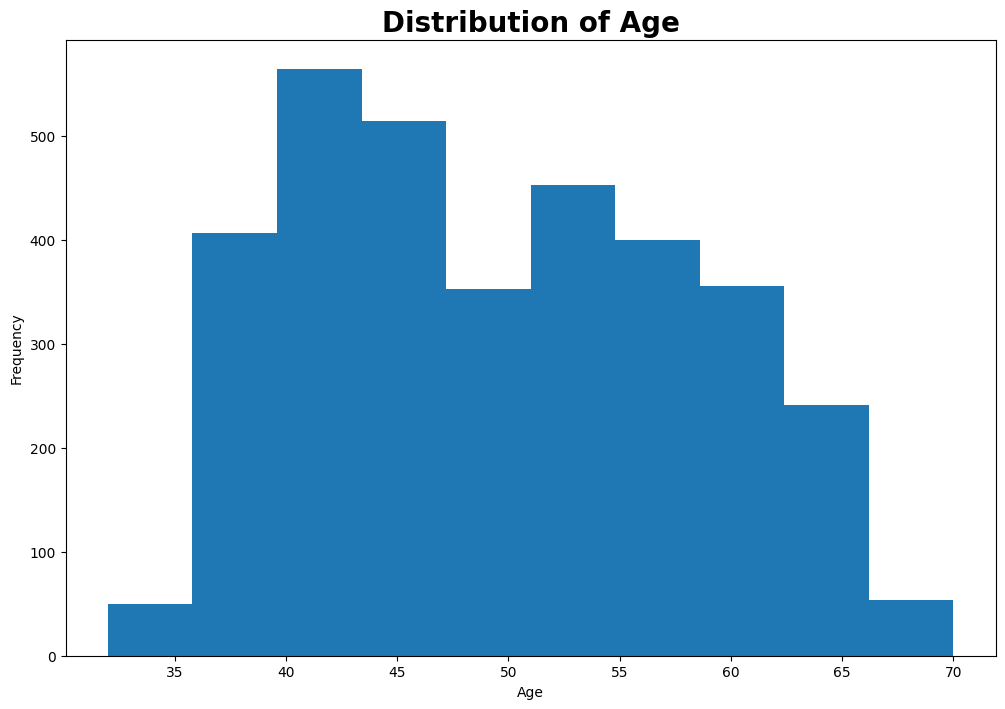

In [8]:
# Histogram of age column

fig,ax = plt.subplots(figsize=(12,8))
ax.hist(x=df['age'])
ax.set(xlabel='Age', ylabel='Frequency')
plt.title(label="Distribution of Age",
          fontdict={"fontsize":20,"fontweight":"bold"})
plt.show()

In [9]:
# Check out Target
target_counts = df['TenYearCHD'].value_counts()
target_counts

TenYearCHD
0    2879
1     511
Name: count, dtype: int64

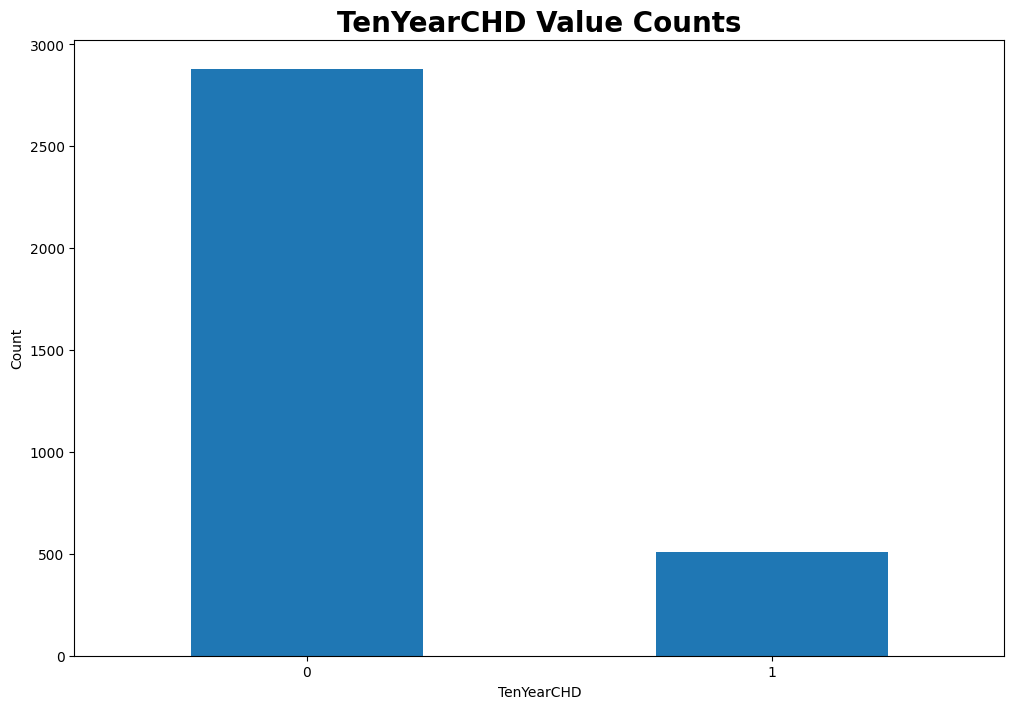

In [10]:
# Plot of Target Count Values
fig,ax = plt.subplots(figsize=(12,8))
target_counts.plot(kind='bar',ax=ax)
ax.set(xlabel='TenYearCHD', ylabel='Count')
plt.xticks(rotation=0)
plt.title(label="TenYearCHD Value Counts",
          fontdict={"fontsize":20,"fontweight":"bold"})
plt.show()

In [11]:
# Make copy of dataset
df_copy = df.copy()
# df_copy.head

# Drop rows with missing values
df_copy = df_copy.dropna(axis=0)

df_copy.isna().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [12]:
# Return names of column with numeric dtype
numeric_dtype_columns = []
for column, value in df_copy.items():
    if value.dtypes!="object":
        numeric_dtype_columns.append(column) 
        
# Function to return columns with outliers
def count_outliers_in_column(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((df[columns]<(Q1 - 1.5*IQR)) | (df[columns]>Q3+1.5*IQR))]
    return outliers[columns].count() 

count_outliers_in_column(df_copy,numeric_dtype_columns)    

id                   0
age                  0
education            0
cigsPerDay           7
BPMeds              88
prevalentStroke     18
prevalentHyp         0
diabetes            79
totChol             34
sysBP               90
diaBP               50
BMI                 72
heartRate           56
glucose            146
TenYearCHD         444
dtype: int64

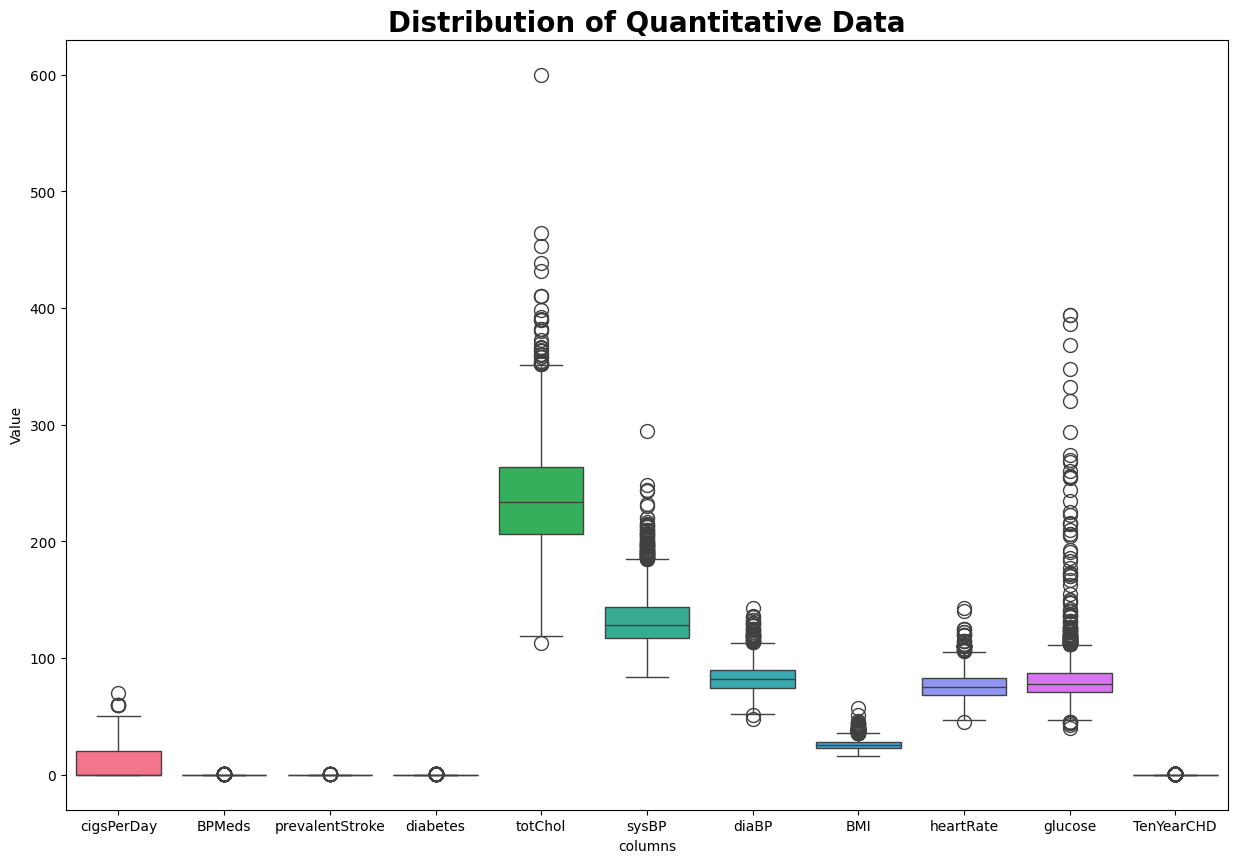

In [13]:
# Boxplot of columns with outliers
fig,ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df_copy.drop(columns=(['id','age','education','prevalentHyp',
                                        'sex','is_smoking'
                                        ]), inplace=False),
            saturation=0.95, fliersize=10,whis=1.5,width=0.8,ax=ax)
ax.set(xlabel='columns',ylabel='Value')
plt.title(label="Distribution of Quantitative Data",
          fontdict={"fontsize":20,"fontweight":"bold"})
plt.show()

In [14]:
# Shape of df_copy
df_copy.shape

(2927, 17)

In [15]:
# Drop outliers in BMI column
Q1 = df_copy['BMI'].quantile(0.25)
Q3 = df_copy['BMI'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df_copy = df_copy[(df_copy['BMI']>lower_bound) & (df_copy['BMI']<upper_bound)]
df_copy.shape

(2855, 17)

In [16]:
# Crosstab of is_smoking and TenYearCHD columns
crosstab = pd.crosstab(df_copy['is_smoking'],df_copy['TenYearCHD'])
crosstab


TenYearCHD,0,1
is_smoking,,
NO,1236,198
YES,1192,229


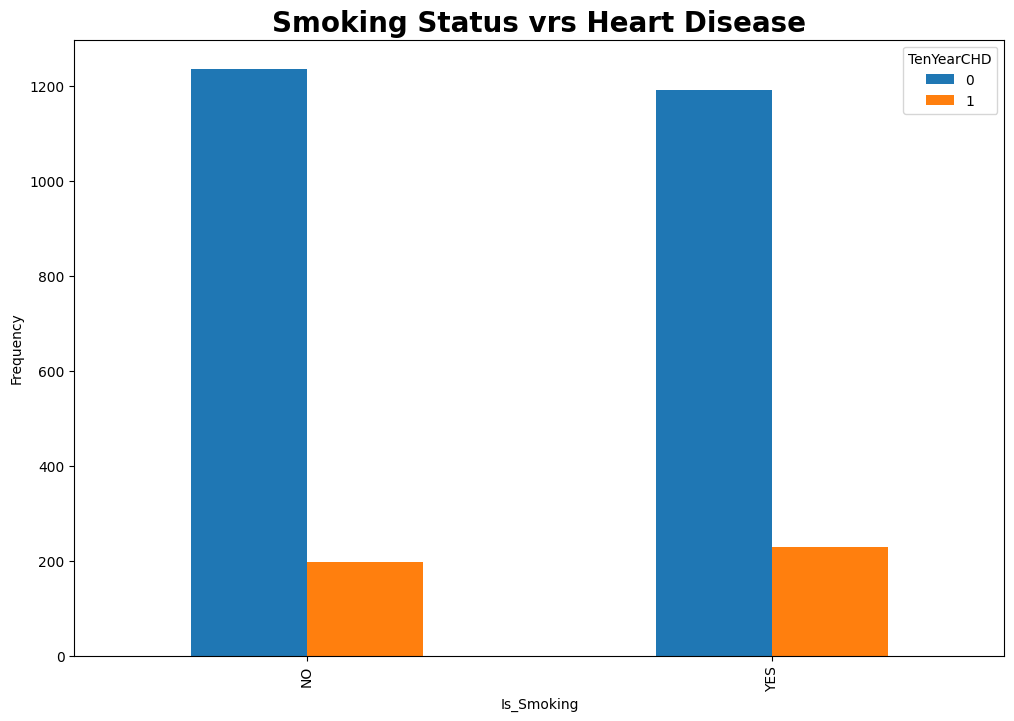

In [17]:
#Bar plot of is_smoking and TenYearCHD crosstab
fig,ax = plt.subplots(figsize=(12,8))
crosstab.plot(kind='bar',ax=ax)
ax.set(xlabel='Is_Smoking',ylabel='Frequency')
plt.title(label="Smoking Status vrs Heart Disease",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

In [18]:
# Number of both sexes
df_copy['sex'].value_counts()

sex
F    1561
M    1294
Name: count, dtype: int64

In [19]:
# Crosstab of sex and TenYearCHD
crosstab = pd.crosstab(df_copy['sex'],df_copy['TenYearCHD'])
crosstab

TenYearCHD,0,1
sex,,
F,1374,187
M,1054,240


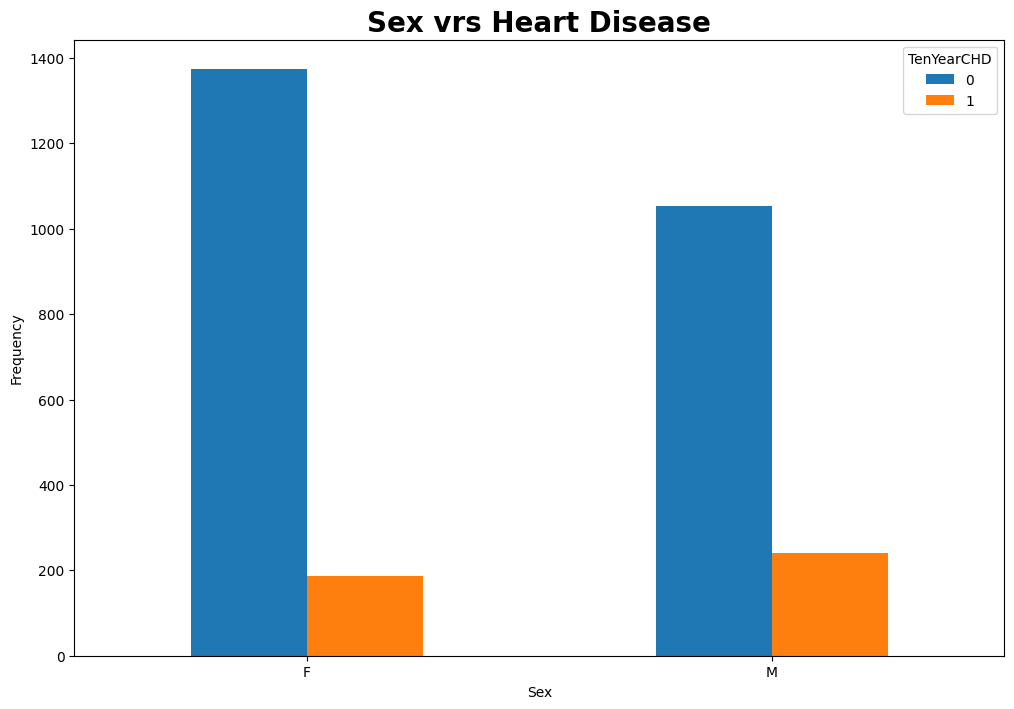

In [20]:
# Barplot of sex and TenYear
fig,ax = plt.subplots(figsize=(12,8))
crosstab.plot(kind='bar',ax=ax)
ax.set(xlabel='Sex',ylabel='Frequency')
plt.xticks(rotation=0)
plt.title(label="Sex vrs Heart Disease",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

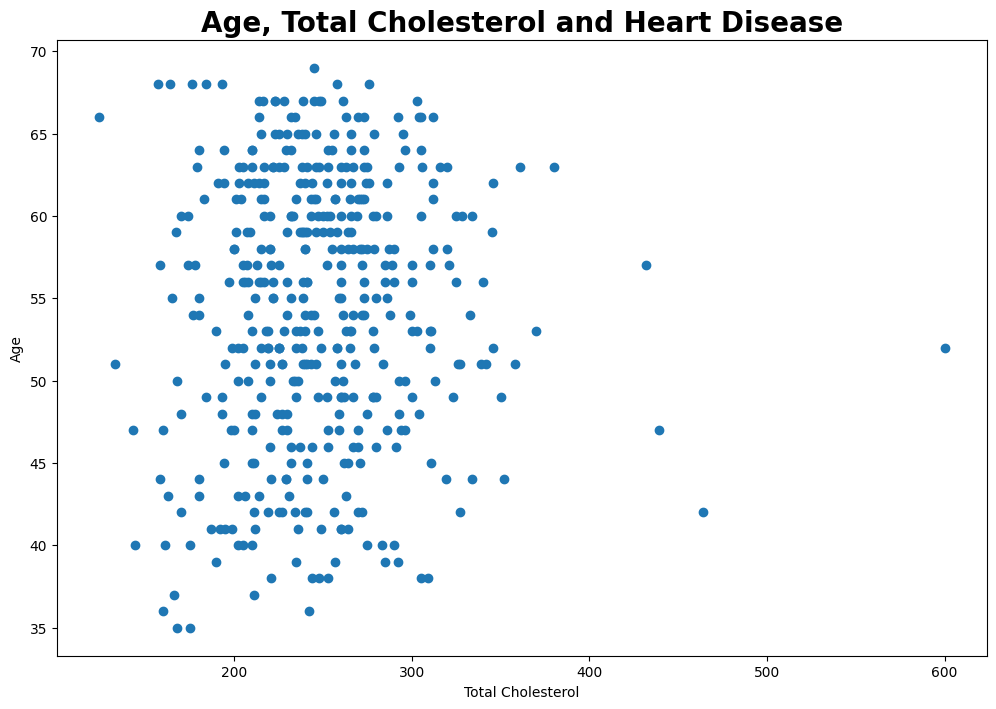

In [21]:
# Scatterplot of age and total cholesterol of people with heart disease

fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(df_copy['totChol'][df_copy['TenYearCHD']==1],
           df_copy['age'][df_copy['TenYearCHD']==1]
        #    ,c='blue'
           )
ax.set(xlabel='Total Cholesterol', ylabel='Age')
plt.title(label="Age, Total Cholesterol and Heart Disease",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()


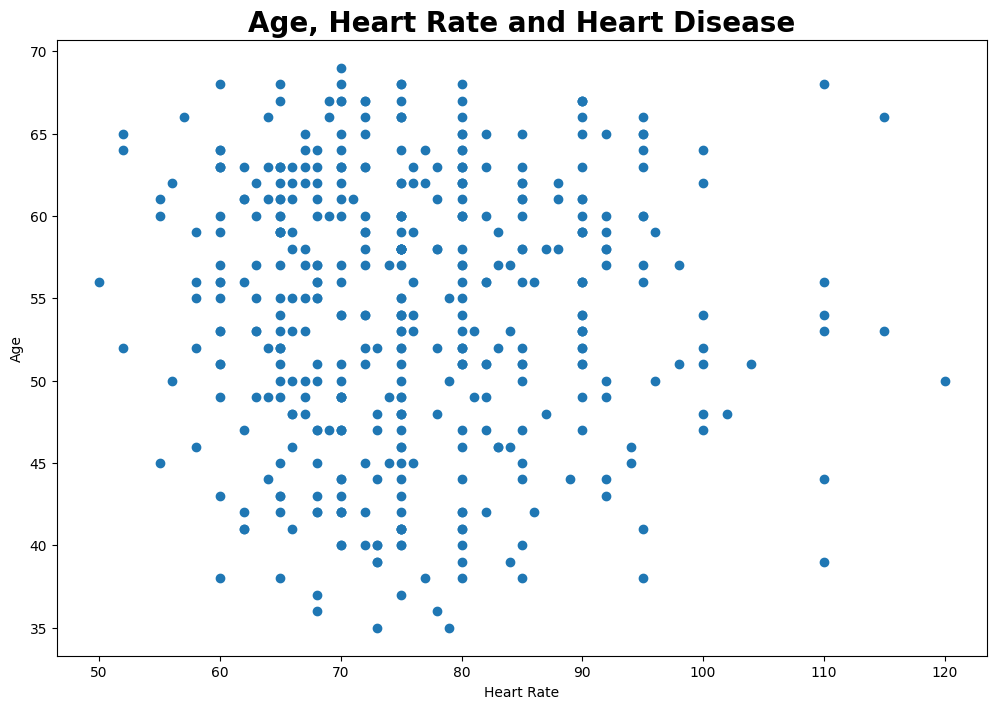

In [22]:
# Scatterplot of age and heart rate of people with heart disease

fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(df_copy['heartRate'][df_copy['TenYearCHD']==1],
           df_copy['age'][df_copy['TenYearCHD']==1])
ax.set(xlabel='Heart Rate', ylabel='Age')
plt.title(label="Age, Heart Rate and Heart Disease",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

In [23]:
# Crosstab of sex and TenYearCHD
crosstab = pd.crosstab(df_copy['education'],df_copy['TenYearCHD'])
crosstab

TenYearCHD,0,1
education,,
1.0,971,216
2.0,756,107
3.0,424,60
4.0,277,44


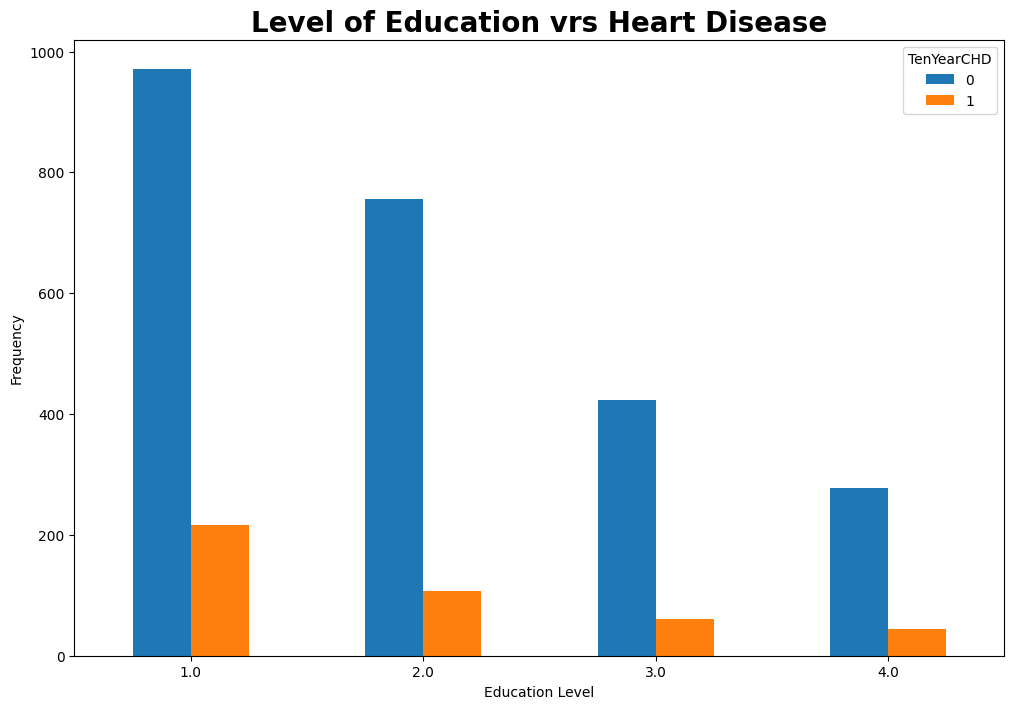

In [24]:
#Bar plot of is_smoking and TenYearCHD crosstab
fig,ax = plt.subplots(figsize=(12,8))
crosstab.plot(kind='bar',ax=ax)
ax.set(xlabel='Education Level',ylabel='Frequency')
plt.xticks(rotation=0)
plt.title(label="Level of Education vrs Heart Disease",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

In [25]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform non-numeric columns
df_copy['sex'] = le.fit_transform(df_copy['sex'])
df_copy['is_smoking'] = le.fit_transform(df_copy['is_smoking'])
df_copy.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1,1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
5,5,61,3.0,0,0,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1


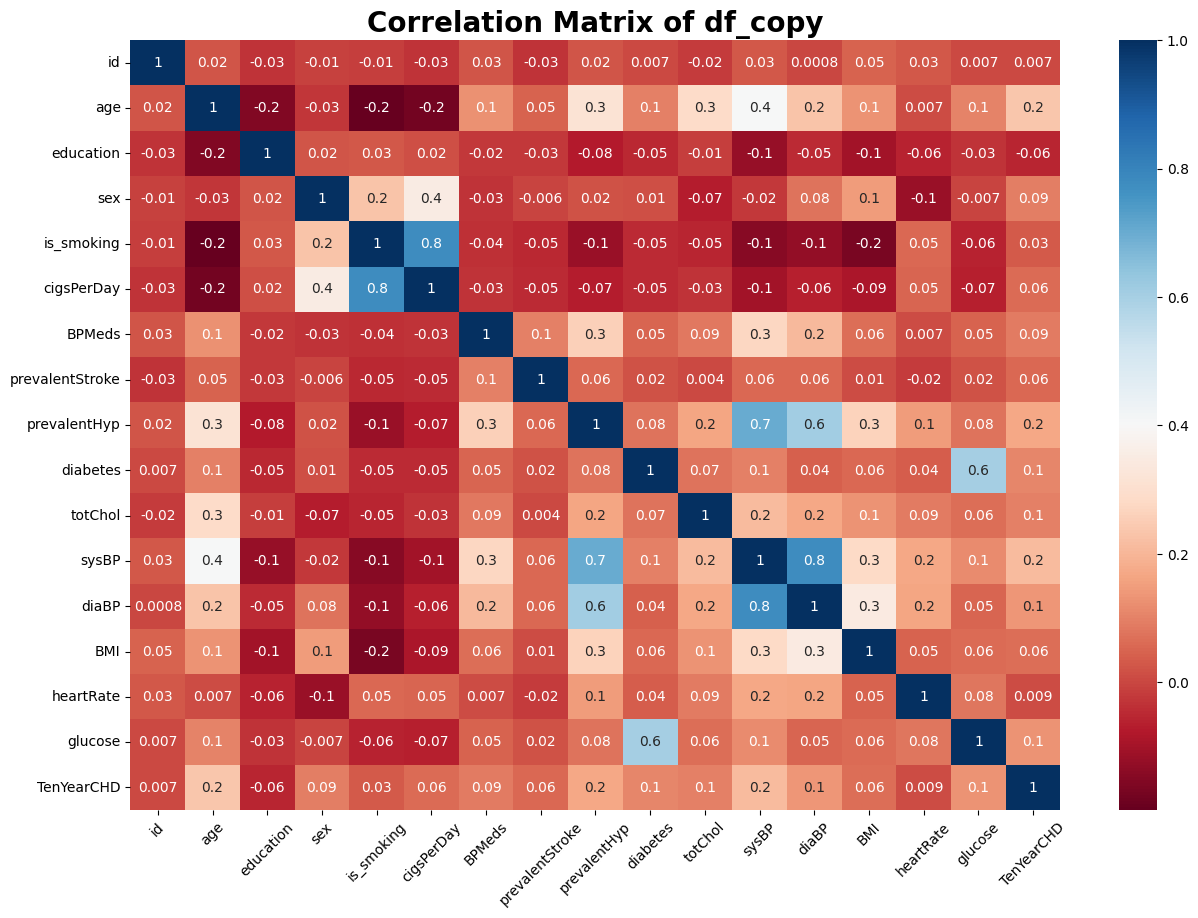

In [26]:
# Heatmap of df_copy

# Compute correlation of df_copy
corr = df_copy.corr(numeric_only=True)

fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,ax=ax,cmap='RdBu',fmt='.0g',
            annot=True,vmax=1)
plt.xticks(rotation=45)
plt.title(label="Correlation Matrix of df_copy",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

In [27]:
# Separate df_copy into X and y
X = df_copy.drop(columns=['TenYearCHD', 'id'])
y =df_copy['TenYearCHD']

# Shape of X and y
X.shape, y.shape

((2855, 15), (2855,))

In [28]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [29]:
# Initialize the logistic regression model
lgr = LogisticRegression()

# Scale df_copy with StandardScaler
ssc = StandardScaler()
X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_test)

# Train model 
lgr.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Evaluate the logistic regression model
test_score = lgr.score(X_test, y_test)

print(f"The accuracy score of the logistic regression model is {test_score*100:.2f}%")

The accuracy score of the logistic regression model is 85.81%


In [31]:
# Hyperparametor tuning

distribution = {'penalty':['l1', 'l2', 'elastic'],
                'max_iter':range(100,800),
                'warm_start':[True, False],
                'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag'],
                'C':np.logspace(-1,1,22)}

# Initialize model parameters

lgrs = RandomizedSearchCV(estimator=LogisticRegression(),
                          param_distributions=distribution,
                          n_iter=100,n_jobs=-1,
                          verbose=1, random_state=42
                          )

# Fit model with data
lgrs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.12451971,  0.15505158,  0.19306977,  0.24040992,
        0.29935773,  0.37275937,  0.46415888,  0.57796929,  0.71968567,
        0.8961505 ,  1.11588399,  1.38949549,  1.73019574,  2.15443469,
        2.6826958 ,  3.34048498,  4.15956216,  5.17947468,  6.44946677,
        8.03085722, 10.        ]),
                                        'max_iter': range(100, 800),
                                        'penalty': ['l1', 'l2', 'elastic'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag'],
                                        'warm_start': [True, False]},
                   random_state=42, verbose=1)

In [32]:
# Get best parameters
best_params = lgrs.best_params_

In [33]:
# Initialize model with best parameters
lgrs_bp = LogisticRegression(**best_params)

In [34]:
# Fit model with best parameters
lgrs_bp.fit(X_test, y_test)

# Get accuracy score
accuracy_score = lgrs_bp.score(X_test, y_test)
print(f"Test model accuracy is {accuracy_score*100:.2f}%")

Test model accuracy is 86.34%


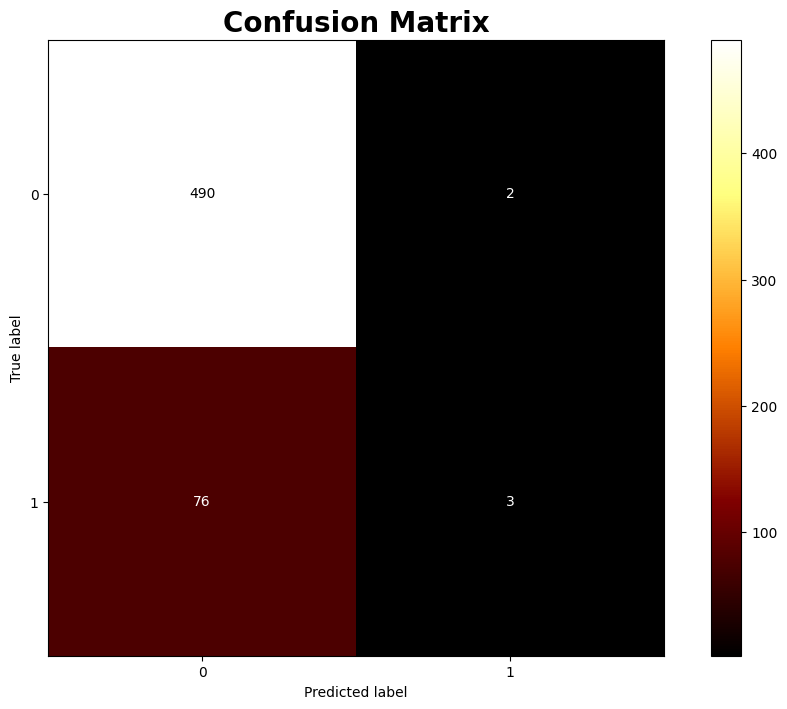

In [35]:
# Predict with model with best parameters
y_pred = lgrs_bp.predict(X_test)

# Plot confusion matrix
fig,ax = plt.subplots(figsize=(12,8))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                               cmap=plt.cm.afmhot,
                                               display_labels=lgrs_bp.classes_,
                                               ax=ax)
plt.title(label="Confusion Matrix",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.show()

In [36]:
# Get class probabilities
y_predicts = lgrs_bp.predict_proba(X_test)[:,1]
# y_predicts
# Compute AUC Score
auc_score = roc_auc_score(y_test, y_predicts)
print(f"The AUC score is {auc_score:.2f}")

The AUC score is 0.77


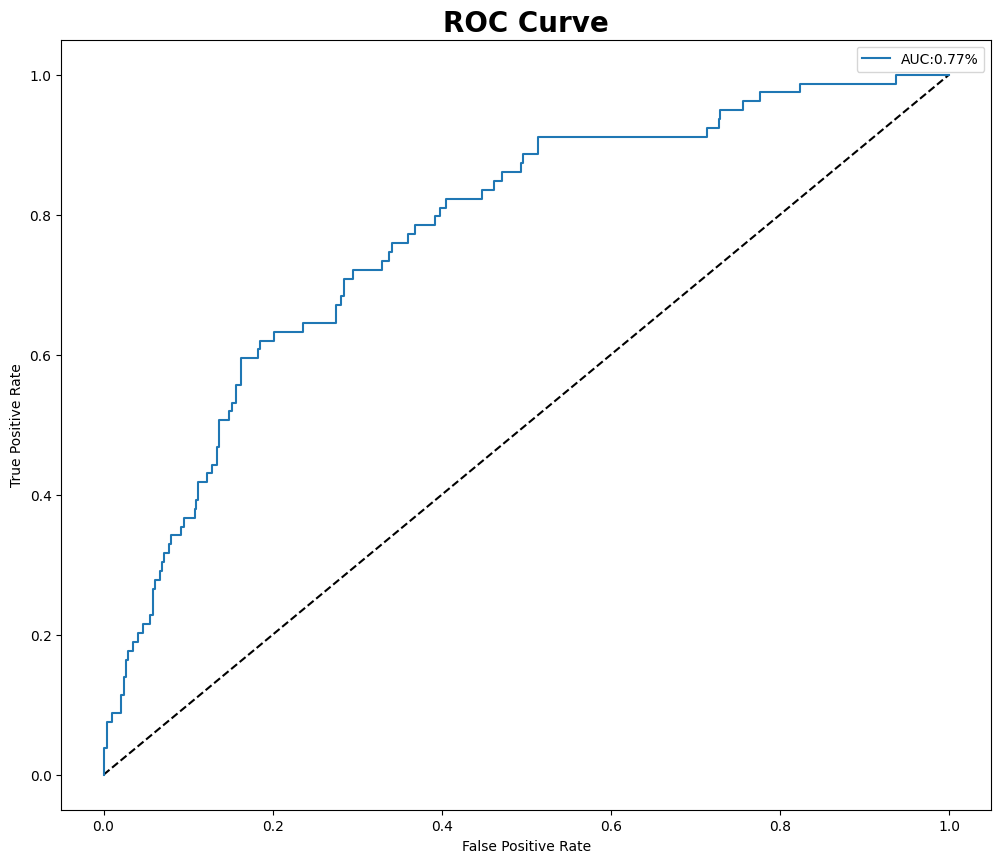

In [41]:
# Plot roc curve

fpr, tpr , thresholds = roc_curve(y_test, y_predicts)

fig,ax = plt.subplots(figsize=(12,10))
ax.plot([0,1], [0,1],'k--')
ax.plot(fpr, tpr,label=f"AUC:{auc_score:.2f}%")
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
plt.title(label="ROC Curve",
          fontdict={'fontsize':20,'fontweight':'bold'})
plt.legend()
plt.show()

In [42]:
# Classification Report
targets = ["No Risk of Heart Disease", "Risk of Heart Disease"]

print(classification_report(y_test, y_pred,target_names=targets))


                          precision    recall  f1-score   support

No Risk of Heart Disease       0.87      1.00      0.93       492
   Risk of Heart Disease       0.60      0.04      0.07        79

                accuracy                           0.86       571
               macro avg       0.73      0.52      0.50       571
            weighted avg       0.83      0.86      0.81       571



In [43]:
# Save the model
with open('lgrs_bp.pkl', 'wb') as file:
    pickle.dump(lgrs_bp, file)

In [44]:
# Load the model
lgrs_bp_loaded = pickle.load(open('lgrs_bp.pkl', 'rb'))

# Test the loaded model
score = lgrs_bp_loaded.score(X_test, y_test)
score

0.8633975481611208